In [ ]:
# The Learning can take upto 20 mins (15k episodes) to learn

# Q-learning with neural networks

In [1]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import math
import torch
import random
from matplotlib.colors import ListedColormap

import pendulum

### **Deep Q Learning Algorithm**
We are given a simulator and have to simulate a pendulum to an inverted position using possible controls [-5, 0, 5] in a way thaat we minimise the cost function:

$min \sum_{n=0}^{100} \alpha^n g(x_n, u_n)$

where $g(\theta,v,u) = 0.01*(1-\cos(\theta-\pi))^2 + 0.001* v^2 + 0.00001*u^2$

$\theta \ and \ v$ are the 2 terms in state variable x and decay factor $\alpha = 0.99.$

Since we do not know the dynamics of the systems, we can solve this optimal control problem, by using a Neural Network to predict our optimal "action value function" Q such that:

$Q(x_n, u_n) = g(x_n, u_n) + \alpha \ min_{u} Q(x_{n+1}, u)$

Action value function Q(x, u) is defined as the cost for applying control u for timstep n and then moving optimally as per the defined policy (choosing controls (u) that minimize the subsequent cost to go).

So to train our Q network, we can run several episodes where we calculate our prediction $Q(x_n, u_n)$ and our target $y_n$ as $g(x_n, u_n) + \alpha \ min_{arg u} Q(x_{n+1}, u)$ and calculate the temporal difference or TD error and perform stochastic gradient descent on it to find our optimal Q network.

<br>



**Algorithm:**

-Initialize $x_0$ as [0, 0] for an episode and find the control $u_0$ using the epsiolon greedy policy:
With probability $(1-\epsilon)$ choose control $u_0$ as the argument that minimises the q values $Q(x_0)$ from our NN.
With probability $\epsilon$ choose random control $u_0$ from possible controls.

-Run pendulum.step() to get next value of $x = x_1$ from our simulator.

-Find target $y_0 = g(x_0, u_0) + \alpha \ min_{u} Q(x_{1}, u)$.

-Find the TD, $Q(x_0, u_0) - y_0$ and perform SGD on it.

-Repeat this step for every timestep of an episode (100 timesteps).

-Continue training for several episodes till minimise the cost, we have also implemented epsilon decay of 0.99* every 20 episodes to make the model trust itself the more it gets trained.

#### Q1) Implementing Deep Q learning algorithm

In [2]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params = torch.zeros_like(params)


### possible controls
possible_controls = np.array([-5.,0.,5.])

In [3]:
#Let us assume if the output for q_function network if first output of D_out is minimum it is -5, if second then 0 if third then 5

#Current step cost
def g(x_t, u_t):
    return 0.01*((1 - np.cos(x_t[0] - np.pi))**2) + 0.001*((x_t[1])**2) + 0.00001*(u_t**2)


def get_eps_greedy_ctrl(x_t, q_function, epsilon):
    #with probability (1-epsilon) we choose control using Q function, otherwise random control for exploration
    if random.random() < (1 - epsilon):
        with torch.no_grad():
            q_vals = q_function(torch.as_tensor(x_t, dtype=torch.float).unsqueeze(0))
            q_min_num = torch.argmin(q_vals)
            u = possible_controls[q_min_num]
    else:
        u = np.random.choice(possible_controls)


    return u

In [4]:
#Model training

#Setup hyperparameters
timesteps = 100
epsilon = 0.3
eps_decay = 0.99
alpha = 0.99
lr = 0.1
x_init = np.array([0,0])

optimizer = torch.optim.SGD(q_function.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
ep_cost = []

for episode in range(15000):
    x_t = x_init
    ep_cost.append(0)
    
    #We decay epsilon every 20 episodes to trust the q_function more as it learns and becomes better
    if episode//20 == 0:
        epsilon = epsilon*0.99

    for i in range(timesteps):
  
        #Choose control using epsilon greedy policy
        u_t = get_eps_greedy_ctrl(x_t, q_function, epsilon)

        #Get intermediete cost (Cost of doing optimal control for this timestep only)
        g_x_t = g(x_t, u_t)

        ep_cost[episode]+= (alpha**i)*g_x_t

        #get our next state values using pendulum.py simlator
        x_next = pendulum.step(x_t, u_t)

        #Value function for x = x_t+1
        q_min_next = torch.min(q_function(torch.as_tensor(x_next, dtype=torch.float).unsqueeze(0)))

        #target Q(xt) = g(xt) + a*Qmin(xt+1)
        y_t = torch.as_tensor(g_x_t, dtype= torch.float) + alpha*q_min_next

        optimizer.zero_grad()
        
        q_vals = q_function.forward(torch.as_tensor(x_t, dtype=torch.float))
        u_num = list(possible_controls).index(u_t)

        #predicted q_value Q(xt)
        q_min_pred = q_vals[u_num]


        #MSE for target and prediction
        loss = loss_fn(q_min_pred, y_t)
        loss.backward()
        optimizer.step()

        x_t = x_next

    print(f"Episode {episode + 1}: Loss = {ep_cost[episode]:.10f}")

Episode 1: Loss = 2.1806860088
Episode 2: Loss = 2.4186797847
Episode 3: Loss = 2.3529344633
Episode 4: Loss = 2.2988120927
Episode 5: Loss = 2.4277527925
Episode 6: Loss = 2.3302448538
Episode 7: Loss = 2.2391795543
Episode 8: Loss = 2.3884043773
Episode 9: Loss = 2.1829381218
Episode 10: Loss = 2.2438244554
Episode 11: Loss = 2.2641537053
Episode 12: Loss = 2.2219507271
Episode 13: Loss = 2.1714990380
Episode 14: Loss = 1.9827978583
Episode 15: Loss = 2.2113475731
Episode 16: Loss = 2.0931012300
Episode 17: Loss = 2.0332975291
Episode 18: Loss = 2.1112313572
Episode 19: Loss = 2.1283788403
Episode 20: Loss = 2.2977149827
Episode 21: Loss = 2.2384688592
Episode 22: Loss = 2.2366982281
Episode 23: Loss = 2.2699164182
Episode 24: Loss = 2.1169753978
Episode 25: Loss = 2.1418028417
Episode 26: Loss = 2.1915659405
Episode 27: Loss = 2.1904496323
Episode 28: Loss = 2.3046092731
Episode 29: Loss = 2.3589106594
Episode 30: Loss = 2.1915618963
Episode 31: Loss = 2.2271208908
Episode 32: Loss 

#### Q1) Testing and simulation with and without push

In [5]:
#Simuating pendulum without push

x0 = np.zeros((2,1))
def controller(x_t):
    with torch.no_grad():
        u_pred = torch.argmin(q_function(torch.as_tensor(x_t, dtype=torch.float).unsqueeze(0))).item()
        # u_pred = q_function(torch.as_tensor(x_t, dtype=torch.float)).argmin()
        u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAcvptZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DPpliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HF7GZUFdO+sBt52dNXPQK5bJ4/5c/PoKHZ4u5LRp1dwcf/Gi0k+s
I8t/gc40AusuUqbkmfCXLEcMdizUt78PG8I27pbGtijO7qG8CaMJTPLYqTODEf5WMtQZbidqD47m
I8VBmQAvCO7K5idTfdLoIBhRxJ/oAG0XfGLFWbb2KowUbin0OeUS9rJQTca4uA0jPn1z15Mb9sF7
knA8XKAxqbGt1sL5tX+BMuFsC3czTwqD8T669fcc5EQoBFCPLNU5yMZD4UzNlIWHNF3GC4J4MUVf
i2GjYE1gFZ560+DWGFqnAks4WM8+IiCyw7yIBNwFP/lgfBito26vtz2964CRrRHlsfr9j0tq4AeR
KIorVv80GWNbYaIVIZLGxtPpYz8yDN9JX/QOQuDy4o0P4MjZwcng9nBRdcKi2KUZu5YwGCAKLhAf
8A2iscLTXm4Up/s9i6iPXfhtrNJG+CuYdnkaaL069Bvn88VFSC6TDK70pBNVOaGijqAB2mMmIg6x
Tu94SMR5b+3RgiRAkc3YuYBUPY8qZ7q8mDeqU8HoW8wiG9K/xDJ1oCxQiiE8wL1YVsNmsYOO0TCc
B1dAQrunxx7uyP/ZQ0bt4TW+rjzhAYNe6wIvfgpJ42uUV1MQ5DPxP5UEcR60quvTj0rLGXSU4qMm
qKycCbkDbYiNfIULHNmAdLHxHpa2LsH0Trrt4F1whlJv6UZOE92Kp29jmwXGshkBihz2IXdQK7MN
950mCV7tUXLonvdoo+XCTTXGto/kmnU+f1aLO5j9Pwsudpz2nNCZc3mue0JTLTSlp9fb9fEfAqAd
jOk5d/0buD6FiAUwTVqXkm3lOjC0JxOwnIaNIHTYgzpAQY4HTSHkEV3UxVP9I4P3jajC+oQI1ESH
9pSmSEsaiMjw5NNzvJAV1FGtwtYFGx/+sz1VS0JrB2uQfc3pOGAynFU7d7jP9sjAeVMR4p+Xb87D
eZRB0NB6EQpJu/s4LRjxRM0wZlnCkN0FvQpSucO64kcWHYu/Ahb4DzNcQeQl51TuiKK36DDNSTkP
X0UcwE6mJ5KyLmFgPPhJuxPVxepKS65DGjGh8ivT+9jtBZmCpksU6fEisRh2bhCJGmjbNchK39Sw
XSFkYKUUFwhxqj/veIKmuO1m7rd3/R3uts3T4Q2Y0s9PTUSjWwaEO6ZEPOi7xjlm5Bo4q2FWdHNa
LaYi8Dq8ud/bsnQPYspvuXN9AkgEiAUqLes33Yo4zQ52A6Ilp7kAIctm+/ijW3sVvpWN++ASRz5P
RufCvH6P3q9FmxxBLLMNspKYLQLP9bmFkhUMpNQ17E4OsqQTF3qkXZVslXT9Zm8jSZQaBRwnocvG
Jj9fTqSI54+1aUK398pavgra5nF1gCAHNMHZ2SY+i1azLvsrEiA1GmSMgsBpA59p/V9Lf59rVpSd
wo2OiuYYvvxFO0wgNiY+zY5VVP0EAPGjicCZddYWIbyaTypr/fN16gq2CtBGnqGxkbUzs8xgkJWh
D3jD/+bwgnkfIOVL6EPORPRnuV7y6/JpgMkZ1xSrcJKpWRrx9CUtIV4mucsEiDGY3t/xbZ+zwiGl
JMmRzvjS7iN6MFf/1gFUteMhZI8AABF+AWjNHF33qAH+5a3OZhKiSjYE7LTyE+Q4fpV9wczcDxWj
lSPexk1rZtXy/h9DKxc2AAjd7LURlAOTQF+vptcbUPsTQkQAuuvWK6CD0fGpgAT8P46odMAYlIZR
wp3h/cCPOHSHBwZ4L6VKHljHWggsgaSa5/n69W1ULhurPip44c0Uh763z09QdzRAuN9PZvVC2xEs
AhTzcqUqfQIP+rfIbskUo9p2KJUatyWwyGRGlZngBBzLJQRwkS/FYtdN0IeJG893mSXz2pSedggr
why0hgABDj2oNBzl28Cbuib89j+mcxlVGq2Pl24gOFWoV55u0JUDndoO3AWH4ILuCdK1Grushgme
aY8LWeG7qtgbZHVAfy3qb336h/GI3WoozPfN/9RTTeLQyeVB2dmVkRBbye6qdEc/6p2ujGHi+HQV
TJfTtjxuAn87f8uQpu863W6s7kN96oAw6VsS5/y54iQvjUC3aSVnas4CrE/m3gTU5DMazl3P+Xvd
IqcctH+SOf/zU6hB9m5NsC9kRQWVCnlGWEE4cDKSzgzGKhMV0fRuy9Tra1CmHMeLZfWBqzCXqjB7
EPORvm64IdsUa7XL7GTVV

In [6]:
#Simuating pendulum with push

x0 = np.zeros((2,1))
def controller(x_t):
    with torch.no_grad():
        u_pred = torch.argmin(q_function(torch.as_tensor(x_t, dtype=torch.float).unsqueeze(0))).item()
        # u_pred = q_function(torch.as_tensor(x_t, dtype=torch.float)).argmin()
        u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=True, save_movie=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAqTxtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DPpliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HF7GZUFdO+sBt52dNXPQK5bJ4/5c/PoKHZ4u5LRp1dwcf/Gi0k+s
I8t/gc40AusuUqbkmfCXLEcMdizUt78PG8I27pbGtijO7qG8CaMJTPLYqTODEf5WMtQZbidqD47m
I8VBmQAvCO7K5idTfdLoIBhRxJ/oAG0XfGLFWbb2KowUbin0OeUS9rJQTca4uA0jPn1z15Mb9sF7
knA8XKAxqbGt1sL5tX+BMuFsC3czTwqD8T669fcc5EQoBFCPLNU5yMZD4UzNlIWHNF3GC4J4MUVf
i2GjYE1gFZ560+DWGFqnAks4WM8+IiCyw7yIBNwFP/lgfBito26vtz2964CRrRHlsfr9j0tq4AeR
KIorVv80GWNbYaIVIZLGxtPpYz8yDN9JX/QOQuDy4o0P4MjZwcng9nBRdcKi2KUZu5YwGCAKLhAf
8A2iscLTXm4Up/s9i6iPXfhtrNJG+CuYdnkaaL069Bvn88VFSC6TDK70pBNVOaGijqAB2mMmIg6x
Tu94SMR5b+3RgiRAkc3YuYBUPY8qZ7q8mDeqU8HoW8wiG9K/xDJ1oCxQiiE8wL1YVsNmsYOO0TCc
B1dAQrunxx7uyP/ZQ0bt4TW+rjzhAYNe6wIvfgpJ42uUV1MQ5DPxP5UEcR60quvTj0rLGXSU4qMm
qKycCbkDbYiNfIULHNmAdLHxHpa2LsH0Trrt4F1whlJv6UZOE92Kp29jmwXGshkBihz2IXdQK7MN
950mCV7tUXLonvdoo+XCTTXGto/kmnU+f1aLO5j9Pwsudpz2nNCZc3mue0JTLTSlp9fb9fEfAqAd
jOk5d/0buD6FiAUwTVqXkm3lOjC0JxOwnIaNIHTYgzpAQY4HTSHkEV3UxVP9I4P3jajC+oQI1ESH
9pSmSEsaiMjw5NNzvJAV1FGtwtYFGx/+sz1VS0JrB2uQfc3pOGAynFU7d7jP9sjAeVMR4p+Xb87D
eZRB0NB6EQpJu/s4LRjxRM0wZlnCkN0FvQpSucO64kcWHYu/Ahb4DzNcQeQl51TuiKK36DDNSTkP
X0UcwE6mJ5KyLmFgPPhJuxPVxepKS65DGjGh8ivT+9jtBZmCpksU6fEisRh2bhCJGmjbNchK39Sw
XSFkYKUUFwhxqj/veIKmuO1m7rd3/R3uts3T4Q2Y0s9PTUSjWwaEO6ZEPOi7xjlm5Bo4q2FWdHNa
LaYi8Dq8ud/bsnQPYspvuXN9AkgEiAUqLes33Yo4zQ52A6Ilp7kAIctm+/ijW3sVvpWN++ASRz5P
RufCvH6P3q9FmxxBLLMNspKYLQLP9bmFkhUMpNQ17E4OsqQTF3qkXZVslXT9Zm8jSZQaBRwnocvG
Jj9fTqSI54+1aUK398pavgra5nF1gCAHNMHZ2SY+i1azLvsrEiA1GmSMgsBpA59p/V9Lf59rVpSd
wo2OiuYYvvxFO0wgNiY+zY5VVP0EAPGjicCZddYWIbyaTypr/fN16gq2CtBGnqGxkbUzs8xgkJWh
D3jD/+bwgnkfIOVL6EPORPRnuV7y6/JpgMkZ1xSrcJKpWRrx9CUtIV4mucsEiDGY3t/xbZ+zwiGl
JMmRzvjS7iN6MFf/1gFUteMhZI8AABF+AWjNHF33qAH+5a3OZhKiSjYE7LTyE+Q4fpV9wczcDxWj
lSPexk1rZtXy/h9DKxc2AAjd7LURlAOTQF+vptcbUPsTQkQAuuvWK6CD0fGpgAT8P46odMAYlIZR
wp3h/cCPOHSHBwZ4L6VKHljHWggsgaSa5/n69W1ULhurPip44c0Uh763z09QdzRAuN9PZvVC2xEs
AhTzcqUqfQIP+rfIbskUo9p2KJUatyWwyGRGlZngBBzLJQRwkS/FYtdN0IeJG893mSXz2pSedggr
why0hgABDj2oNBzl28Cbuib89j+mcxlVGq2Pl24gOFWoV55u0JUDndoO3AWH4ILuCdK1Grushgme
aY8LWeG7qtgbZHVAfy3qb336h/GI3WoozPfN/9RTTeLQyeVB2dmVkRBbye6qdEc/6p2ujGHi+HQV
TJfTtjxuAn87f8uQpu863W6s7kN96oAw6VsS5/y54iQvjUC3aSVnas4CrE/m3gTU5DMazl3P+Xvd
IqcctH+SOf/zU6hB9m5NsC9kRQWVCnlGWEE4cDKSzgzGKhMV0fRuy9Tra1CmHMeLZfWBqzCXqjB7
EPORvm64IdsUa7XL7GTVV

#### 2) Plotting Cost per episode

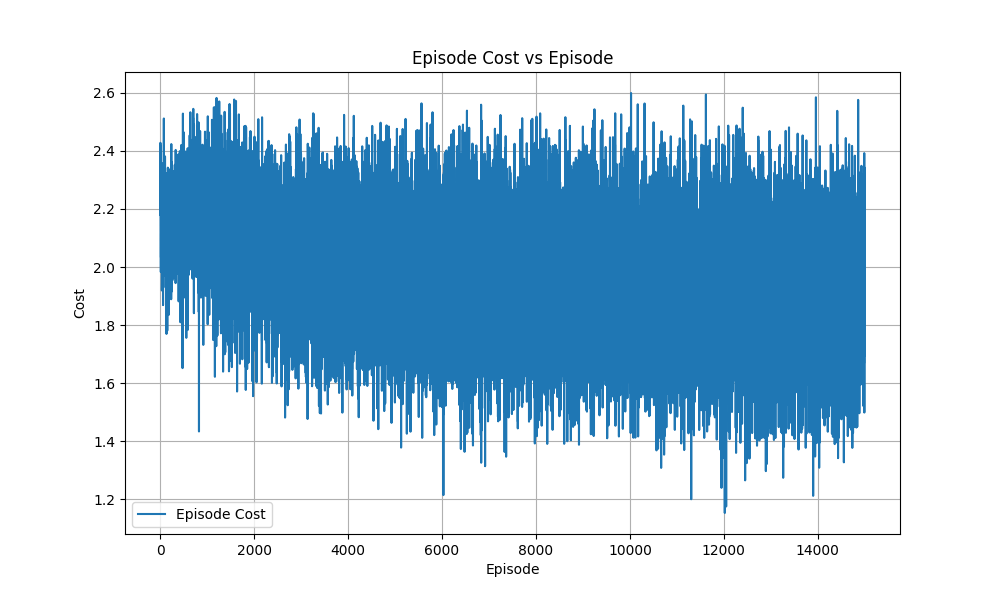

In [7]:
#Plotting Cost function value per episode

episodes = range(1, len(ep_cost) + 1)

plt.figure(figsize=(10, 6))  
plt.plot(episodes, ep_cost, label='Episode Cost')
plt.xlabel('Episode')      
plt.ylabel('Cost')         
plt.title('Episode Cost vs Episode')  
plt.legend()               
plt.grid(True)             
plt.show()                 

#### Q3) Plot of Value function and Policy v theta and velocity

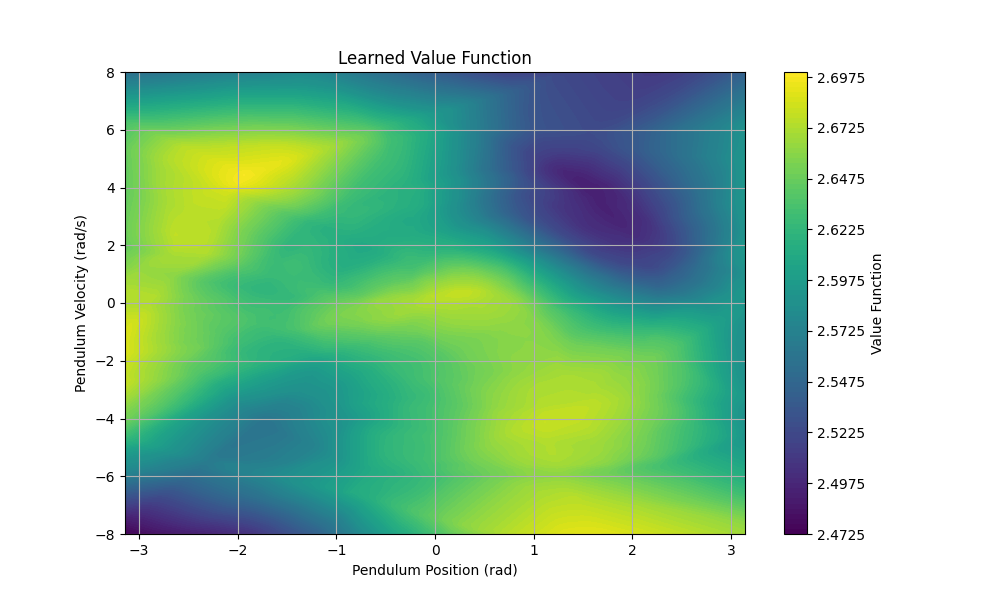

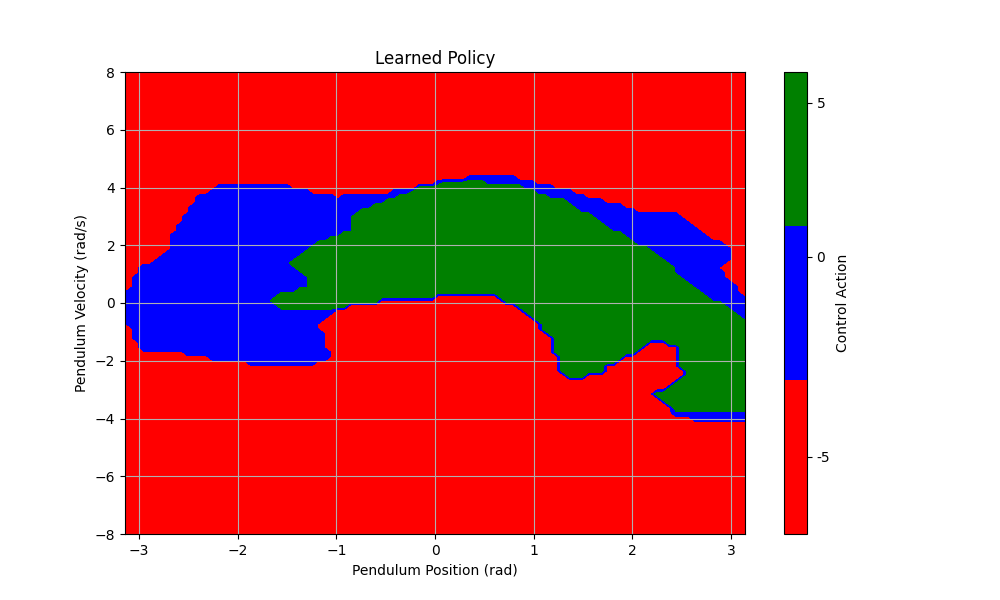

In [8]:
# Creating a grid of various positions and velocities
position_range = np.linspace(-np.pi, np.pi, 100)  
velocity_range = np.linspace(-8, 8, 100)          
position_grid, velocity_grid = np.meshgrid(position_range, velocity_range)

value_function = np.zeros_like(position_grid)
policy = np.zeros_like(position_grid)

# Evaluate Q-function and policy for every possible theta and velocity values

for i in range(position_grid.shape[0]):
    for j in range(position_grid.shape[1]):
        # Current state
        x_t = torch.tensor([position_grid[i, j], velocity_grid[i, j]], dtype=torch.float)

        with torch.no_grad():
            q_vals = q_function(x_t.unsqueeze(0))  # Evaluate Q-function
            value_function[i, j] = torch.min(q_vals).item()  # Min Q-value as the value function
            policy[i, j] = possible_controls[torch.argmin(q_vals).item()]  # Corresponding policy

# Plot the value function
plt.figure(figsize=(10, 6))
plt.contourf(position_grid, velocity_grid, value_function, levels=100, cmap='viridis')
plt.colorbar(label='Value Function')
plt.xlabel('Pendulum Position (rad)')
plt.ylabel('Pendulum Velocity (rad/s)')
plt.title('Learned Value Function')
plt.grid(True)
plt.show()

# Plot the policy with distinct colors for control actions
plt.figure(figsize=(10, 6))

# Custom discrete colormap
cmap = ListedColormap(['red', 'blue', 'green'])  # Colors for -5, 0, and 5
contour = plt.contourf(
    position_grid, velocity_grid, policy,
    levels=[-6, -4, 1, 6],  
    cmap=cmap
)

# Add colorbar with custom labels
cbar = plt.colorbar(contour, ticks=[-5, 0, 5])
cbar.ax.set_yticklabels(['-5', '0', '5'])
cbar.set_label('Control Action')

# Label the plot
plt.xlabel('Pendulum Position (rad)')
plt.ylabel('Pendulum Velocity (rad/s)')
plt.title('Learned Policy')
plt.grid(True)
plt.show()


In [9]:
#Simulating again to calculate optimal states and correpsonding value function and policy during pendulum trajectory

x_t = np.array([0,0])
thetas = []
velocities = []
value_func = []
policy = []
with torch.no_grad():
    for i in range(100):

        thetas.append(x_t[0])
        velocities.append(x_t[1])

        q_vals = q_function(torch.as_tensor(x_t, dtype=torch.float).unsqueeze(0))
        value_func.append(torch.min(q_vals))
        policy.append(possible_controls[torch.argmin(q_vals).item()])

        x_next = pendulum.step(x_t, policy[i])
        x_t = x_next

for i in range(len(thetas)):
    if thetas[i] > math.pi:
        thetas[i] = thetas[i] - 2*math.pi

C:\Users\megh2\AppData\Local\Temp\ipykernel_33212\1182337010.py:47: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(theta_grid, velocity_grid, vf_nan_mask, levels=[0.5, 1], colors='gray', alpha=0.6, label='Unobserved Areas')


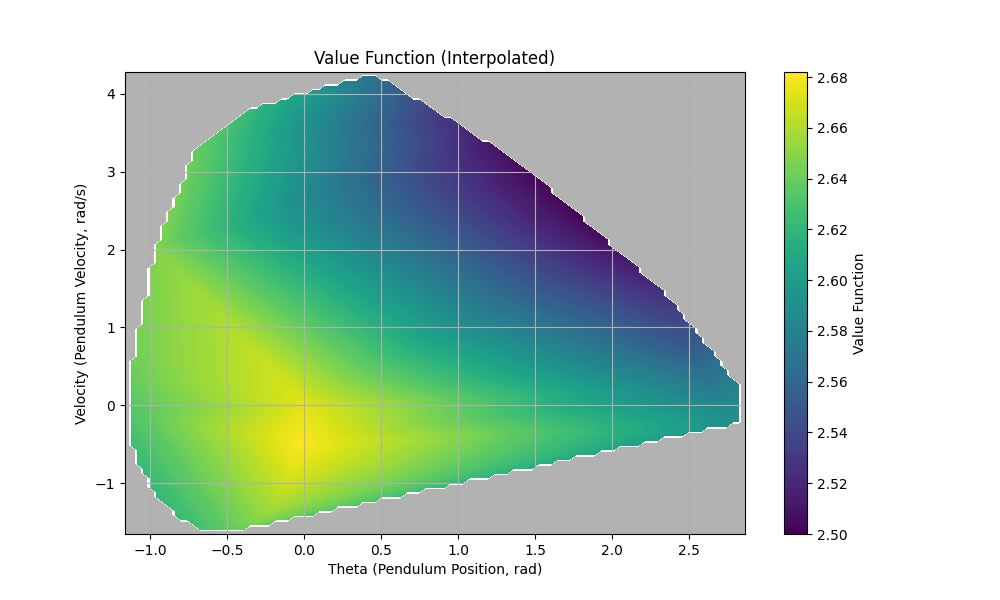

C:\Users\megh2\AppData\Local\Temp\ipykernel_33212\1182337010.py:72: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(theta_grid, velocity_grid, p_nan_mask, levels=[0.5, 1], colors='gray', alpha=0.6, label='Unobserved Areas')


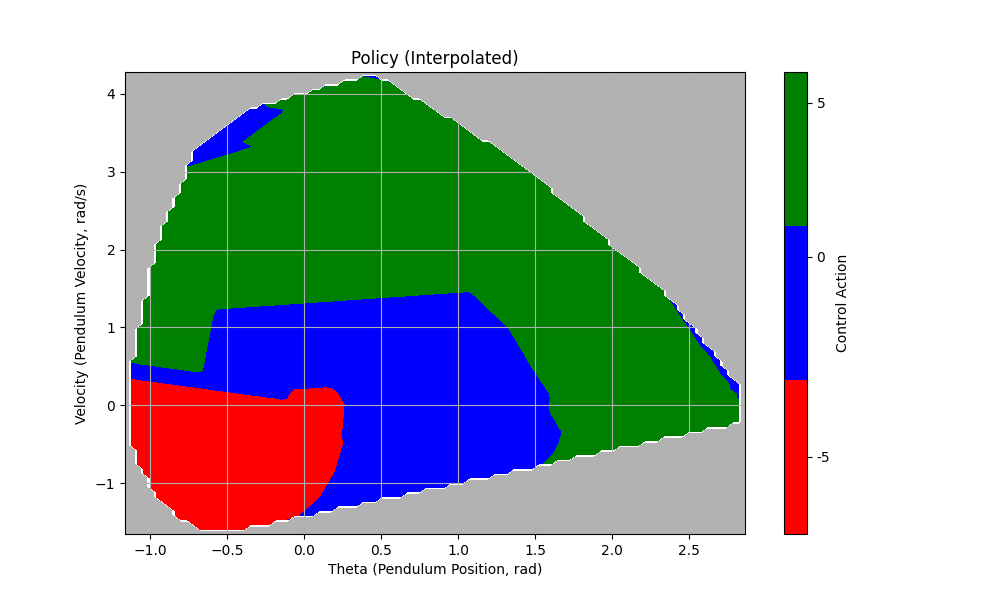

In [10]:
#Plotting Value function and Policy as a function of states theta and velocity during simulated pendulum trajcetory

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

thetas = np.array(thetas).flatten()
velocities = np.array(velocities).flatten() 
value_function = np.array(value_func).flatten()
policy = np.array(policy).flatten() 


# Create a regular grid for interpolation
theta_grid, velocity_grid = np.meshgrid(
    np.linspace(thetas.min(), thetas.max(), 100),
    np.linspace(velocities.min(), velocities.max(), 100)
)

# Interpolate the observed value function onto the grid
value_function_grid = griddata(
    points=(thetas, velocities),
    values=value_function, 
    xi=(theta_grid, velocity_grid),
    method='linear'
)

# Handle any NaN values that may arise from interpolation
vf_nan_mask = np.isnan(value_function_grid)


# Interpolate the observed value function onto the grid
policy_grid = griddata(
    points=(thetas, velocities),
    values=policy,
    xi=(theta_grid, velocity_grid), 
    method='linear'
)

# Handle any NaN values that may arise from interpolation
p_nan_mask = np.isnan(policy_grid)

# Plot the interpolated Value Function
plt.figure(figsize=(10, 6))
contour = plt.contourf(theta_grid, velocity_grid, value_function_grid, levels=100, cmap='viridis')
plt.colorbar(contour, label='Value Function')

plt.contourf(theta_grid, velocity_grid, vf_nan_mask, levels=[0.5, 1], colors='gray', alpha=0.6, label='Unobserved Areas')

plt.xlabel('Theta (Pendulum Position, rad)')
plt.ylabel('Velocity (Pendulum Velocity, rad/s)')
plt.title('Value Function (Interpolated)')
plt.grid(True)
plt.show()

# Plot the interpolated Policy
plt.figure(figsize=(10, 6))
contour = plt.contourf(theta_grid, velocity_grid, policy_grid, levels=100, cmap='viridis')

# Custom discrete colormap
cmap = ListedColormap(['red', 'blue', 'green'])  # Colors for -5, 0, and 5
contour = plt.contourf(
    theta_grid, velocity_grid, policy_grid,
    levels=[-6, -4, 1, 6],  
    cmap=cmap
)

# Add colorbar with custom labels
cbar = plt.colorbar(contour, ticks=[-5, 0, 5])
cbar.ax.set_yticklabels(['-5', '0', '5'])
cbar.set_label('Control Action')

plt.contourf(theta_grid, velocity_grid, p_nan_mask, levels=[0.5, 1], colors='gray', alpha=0.6, label='Unobserved Areas')

plt.xlabel('Theta (Pendulum Position, rad)')
plt.ylabel('Velocity (Pendulum Velocity, rad/s)')
plt.title('Policy (Interpolated)')
plt.grid(True)
plt.show()
